Welcome to the DL in Inverse Scattering Tutorial. Through this notebook, we aim to provide a step-by-step introduction to codes used in implemenation of the scheme provided in <i>Embedding Deep Learning in Inverse Scattering Problem</i>. After going through this notebook, one can perform the numerical experiments themselves to generate the results presented in our aforementioned paper. 

The link to original paper can be found <a href = "https://ieeexplore.ieee.org/document/8709721">here</a>. We have also provided a link to slides of corresponding conference paper presented at URSI-APRASC 2019 Delhi <a href="https://sanghviyashiitb.github.io/blog/2019-3-31-URSI">here</a>.


To start off, we firstly need to initialize some problem parameters. Since our scheme is heavily using Subspace Optimization Method (SOM), we use the parameters as ones used in the original SOM paper i.e. <a href = "https://ieeexplore.ieee.org/abstract/document/5210141">Subspace-Based Optimization Method for Solving Inverse-Scattering Problems</a>.

The imaging domain, $D$, is assumed to be of size $2m \times 2m$ and the object of interest is located within this domain. The incident field is $400MHz$, and hence the free space wavelength is $\lambda = 0.75m$. The measurements are taken on a circle of radius $R_S = 4m$ with the centre of the circle coinciding with the center of $D$ and $N_s = 32$ receivers are placed along the measurement domain in an equiangular manner for each illuminations. Total number of different illuminations are $N_I = 16$ and the corresponding transceivers are placed on the radius $R_i = 6m$.

In [1]:
import sys
sys.path.insert(0, './utility/')
sys.path.insert(0, './SOM_CSI/')
import numpy as np
import generate_shapes
import matplotlib.pyplot as plt

# Frequency = 400MHz
f = 4e8
wavelength = 3e8/f

# k := Wavenumber
k = 2*np.pi/wavelength 

# d := Dimension of imaging domain D in meters
d = 2 

# R := Radius of measurement domain
R = 4

# M := Number of Receivers per illumination
M = 32

# V := Number of illuminations
V = 16

Given these paramters, we can generate other quantities such as positions of discretized grids, receivers and transceivers. Additionally, we also need the incident field vector for the inverse scattering problem

In [2]:
import setup_functions

# The imaging domain is discretized into L X L cells
L = 32 
# Dimension of one cell
n = d/L 
# Number of pixels
N = L^2

# Positions of center of each grid. Shape = [N, 2]
# pos_D[i,:] = [x coordinate, y coordinate] of cell #i 
pos_D = setup_functions.gen_pos_D(d,L,n)

# Positions of Receivers and Transceivers. Shape = [M,2] and [V,2] respectively
# pos_S[i,:] = [x coordinate, y coordinate] of receiver #i 
pos_S = setup_functions.gen_pos_S(R, M, d) 
# pos_Tx[i,:] = [x coordinate, y coordinate] of transceiver #i 
pos_Tx = setup_functions.gen_pos_Tx(R*1.5, V, d)

# Incident Field, Shape = [N,1] (Complex vector)
e = setup_functions.gen_e(k, pos_D, pos_Tx)

Next, we need the scattered fields which will be used to obtain the dielectric profile. In absence of actual data, we simulate the experimental data by running the forward solver at a higher resolution ($L = 100$) in this case. 

In [3]:
# For forward solver
L_forward = 32
n_forward = d/L_forward

pos_D_forward = setup_functions.gen_pos_D(d,L_forward,n_forward)
e_forward = setup_functions.gen_e(k, pos_D_forward, pos_Tx)

We use the CG-FFT forward solver to find out the internal fields and then calculate the scattered fields at external points using the matrix $G_S$. The process can be summarized as follows:
$$d_n =  e_n + G_DXe_n$$
$$\Rightarrow w_n = Xe_n + XG_Dw_n$$
$$ s_n = G_S w_n $$

Note that the symbols used have the same meaning as those defined in our paper.

In [4]:
import util_cgfft
import util_functions
# Forward Solver parameters for L = 100 
# FFT representation of G_D matrix
g_D_forward, g_D_fft_forward, g_D_fft_conj_forward = util_cgfft.construct_g_D(pos_D_forward, k, n_forward)

# G_S matrix for forward solver
G_S_forward = util_functions.construct_G_S(pos_D_forward, pos_S, k, n_forward)

# Forward Solver parameters for L = 32 
G_D = util_functions.construct_G_D(pos_D, k, n)
# FFT representation of G_D matrix
g_D, g_D_fft, g_D_fft_conj = util_cgfft.construct_g_D(pos_D, k, n)

# G_S matrix for inverse solver solver
G_S = util_functions.construct_G_S(pos_D, pos_S, k, n)


############################################################# 
# Generating parameters for Inversion at 16 X 16 Resolution
#############################################################
L1 = 16
n_L1 = d/L1

pos_D_L1 = setup_functions.gen_pos_D(d,L1,n_L1)
e_L1 = setup_functions.gen_e(k, pos_D_L1, pos_Tx)

g_D_L1, g_D_fft_L1, g_D_fft_conj_L1 = util_cgfft.construct_g_D(pos_D_L1, k, n_L1)
G_S_L1 = util_functions.construct_G_S(pos_D_L1, pos_S, k, n_L1)
G_D_L1 = util_functions.construct_G_D(pos_D_L1, k, n_L1)

## Ignore the warning which comes after running the code

/anaconda3/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


But what object we are going to run the forward solver on? We use the Austria profile which is often used to validate inverse scattering algorithms. However, we increase the contrast of the profile to make an electrically stronger object for which conventional algorithms fail

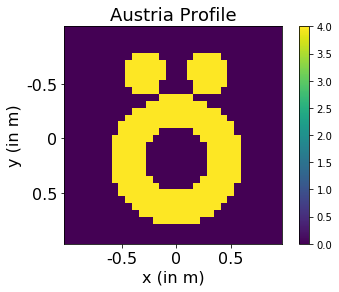

In [5]:

max_contrast = 4.0
x_au = generate_shapes.austria_multicontrast(L_forward,max_contrast,max_contrast,max_contrast)

# Display Austria Profile
plt.imshow(np.real(x_au))
plt.xticks([L_forward*0.25, L_forward*0.5, L_forward*0.75], [-0.5, 0, 0.5],fontsize = '16')
plt.yticks([L_forward*0.25, L_forward*0.5, L_forward*0.75], [-0.5, 0, 0.5],fontsize = '16')
plt.xlabel('x (in m)', fontsize='16')
plt.ylabel('y (in m)', fontsize='16')
plt.title('Austria Profile', fontsize='18')
plt.colorbar()

The CG-FFT solver is used to generate scattered field data which will be later used in the inversion process.

In [6]:
# Generating scattered field from profile
# Reshape profile into [N,1] vector
x = np.reshape(x_au,[L_forward*L_forward,1])
# Run the forward solver
print('Running Forward Solver for %d illuminations'%(V))
print('This might take a while...')
y, _ = util_cgfft.cg_fft_forward_problem(x, G_S_forward, g_D_fft_forward, e_forward, 1e-6, e_forward, 1000)
# Add 25dB Gaussian Noise
print('Completed running the solver.')
y = util_functions.add_noise(y, 25)

Running Forward Solver for 16 illuminations
This might take a while...


/anaconda3/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Tolerance = 0.430e-6 at iteration = 210 for 1th illumination
Tolerance = 0.873e-6 at iteration = 216 for 2th illumination
Tolerance = 0.536e-6 at iteration = 218 for 3th illumination
Tolerance = 0.153e-6 at iteration = 217 for 4th illumination
Tolerance = 0.584e-6 at iteration = 122 for 5th illumination
Tolerance = 0.129e-6 at iteration = 216 for 6th illumination
Tolerance = 0.630e-6 at iteration = 221 for 7th illumination
Tolerance = 0.285e-6 at iteration = 218 for 8th illumination
Tolerance = 0.739e-6 at iteration = 212 for 9th illumination
Tolerance = 0.130e-6 at iteration = 220 for 10th illumination
Tolerance = 0.560e-6 at iteration = 226 for 11th illumination
Tolerance = 0.667e-6 at iteration = 215 for 12th illumination
Tolerance = 0.835e-6 at iteration = 122 for 13th illumination
Tolerance = 0.714e-6 at iteration = 213 for 14th illumination
Tolerance = 0.549e-6 at iteration = 215 for 15th illumination
Tolerance = 0.438e-6 at iteration = 215 for 16th illumination
Completed running

Firstly, we try to reconstruct the original profile from scattered field through plain SOM. As we'll see, the reconstruction would fail as the underlying object is too small. 

In [7]:
############################################# 
# Running SOM Solver at 32 X 32 Resolution
#############################################
from SOM import SOM_SingularValues_Morozov, SOM_Stage_II_CGFFT_TV, TSOM_withCGFFT_TV

# SVD of G_S, used in extracting row-space components
U1, s1, V1h = np.linalg.svd(G_S, full_matrices=False)
S1 = np.diag(s1)
V1 = V1h.conj().T
# Extract row space components from scattered field data
w_RS, _ = SOM_SingularValues_Morozov(y, G_S, U1, S1, V1, 25)
# Convert w_RS to equivalent contrast
d_0 =  e + util_cgfft.G_D_into_x(g_D_fft, w_RS)
x_RS = np.reshape( np.sum(d_0.conj()*w_RS, axis = 1)/np.sum(d_0.conj()*d_0,axis=1), (L*L,1) )
# Use TSOM+TV to extract the 
x_L2, _, _ = TSOM_withCGFFT_TV(y, G_S, G_D, g_D_fft, g_D_fft_conj, e, w_RS, 0, False, 500, 2000, 25, 1e-4)
x_L2 = np.real(x_L2)*(np.real(x_L2) >= 0) + 1j*np.imag(x_L2)*(np.imag(x_L2) <= 0)



Number of Singular Values used: 20
Number of Singular Values used: 20


/anaconda3/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


ADMM_Elapsed Time: 0.482
Iteration: 0, Cost function: 12.28658
SOM Iteration time: 0.671
ADMM_Elapsed Time: 0.076
Iteration: 1, Cost function: 10.55251
SOM Iteration time: 0.286
ADMM_Elapsed Time: 0.107
Iteration: 2, Cost function: 9.25895
SOM Iteration time: 0.354
ADMM_Elapsed Time: 0.063
Iteration: 3, Cost function: 8.50582
SOM Iteration time: 0.297
ADMM_Elapsed Time: 0.072
Iteration: 4, Cost function: 7.92397
SOM Iteration time: 0.287
ADMM_Elapsed Time: 0.068
Iteration: 5, Cost function: 7.34927
SOM Iteration time: 0.284
ADMM_Elapsed Time: 0.074
Iteration: 6, Cost function: 7.05185
SOM Iteration time: 0.286
ADMM_Elapsed Time: 0.073
Iteration: 7, Cost function: 6.76924
SOM Iteration time: 0.278
ADMM_Elapsed Time: 0.070
Iteration: 8, Cost function: 6.55737
SOM Iteration time: 0.279
ADMM_Elapsed Time: 0.075
Iteration: 9, Cost function: 6.34039
SOM Iteration time: 0.287
ADMM_Elapsed Time: 0.070
Iteration: 10, Cost function: 6.16732
SOM Iteration time: 0.274
ADMM_Elapsed Time: 0.075
...I

ADMM_Elapsed Time: 0.072
Iteration: 921, Cost function: 2.64407
SOM Iteration time: 0.296
ADMM_Elapsed Time: 0.065
Iteration: 922, Cost function: 2.64384
Time elapsed:  317.38625717163086


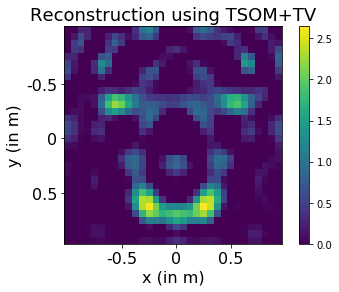

In [8]:
# Display Reconstruction of Austria Profile
plt.imshow(np.real(np.reshape(x_L2,[L,L])))
plt.xticks([L*0.25, L*0.5, L*0.75], [-0.5, 0, 0.5],fontsize = '16')
plt.yticks([L*0.25, L*0.5, L*0.75], [-0.5, 0, 0.5],fontsize = '16')
plt.xlabel('x (in m)', fontsize='16')
plt.ylabel('y (in m)', fontsize='16')
plt.title('Reconstruction using TSOM+TV', fontsize='18')
plt.colorbar()

As it might be clear from the reconstruction using SOM, Austria contrast 4 profile is too strong an object to recover. The original shape (a ring and 2 disks) is not recovered and the contrast of the reconstructed object is also too low.  

Our method provides a way to circumvent this issue. The idea is to learn and use the underlying prior of the object to get a better estimate the null subspace of the contrast source. This estimate is further refined by optimizing the cost function used in SOM,by using the null-space estimate as an initialization.

To start with, lets obtain the row space coefficient of the contrast source at a 16X16 discretization of the imaging domain.

In [9]:
# SVD of G_S, used in extracting row-space components
U1, s1, V1h = np.linalg.svd(G_S_L1, full_matrices=False)
S1 = np.diag(s1)
V1 = V1h.conj().T

# Extract row space components from scattered field data
w_RS_L1, _ = SOM_SingularValues_Morozov(y, G_S_L1, U1, S1, V1, 25)

Number of Singular Values used: 20


Now that we have a rowspace component, we use a novel convolutional network <i>CS-Net</i> which is trained to predict the noise subspace from the row subspace component of the contrast source. In the following snippet of code, we load a pre-trained CS-Net model and push the signal subspace of the contrast source to it. At the end, we get a prediction of the noise-space. 

In [10]:
import torch
from ContrastSourceNet import ContrastSourceNet_16_MultiScale_2

# Load the trained CS-Net
MODEL_L16_FILE = './best_models_yet/ContrastSourceNet_noisydata_25SNR_L16.pth'
cs_net = ContrastSourceNet_16_MultiScale_2(V)
cs_net.load_state_dict(torch.load(MODEL_L16_FILE))

CSImage_input_L1 = np.expand_dims( util_functions.convert_w_to_CSImage(w_RS_L1),axis = 0) 
CSImage_output_L1 = cs_net( torch.Tensor(CSImage_input_L1) ).detach().numpy()
w_DL = util_functions.convert_CSImage_to_w(np.squeeze(CSImage_output_L1, axis=0))

The total contrast source is used to initialize optimization of the SOM cost function, effectively avoiding the local minima which is often an issue while recovering the electrically strong objects.

In [12]:
d_0 =  e_L1 + util_cgfft.G_D_into_x(g_D_fft_L1, w_DL)
x_DL = np.reshape( np.sum(d_0.conj()*w_DL, axis = 1)/np.sum(d_0.conj()*d_0,axis=1), (L1*L1,1) )
x_DL_SOM, w_DL_SOM, _ = TSOM_withCGFFT_TV(y, G_S_L1, G_D_L1, g_D_fft_L1, g_D_fft_conj_L1, e_L1, w_DL, x_DL, False, 256, 2000, 25, 0)


/anaconda3/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Number of Singular Values used: 20
Iteration: 0, Cost function: 156.35654
SOM Iteration time: 0.063
Iteration: 1, Cost function: 120.17980
SOM Iteration time: 0.067
Iteration: 2, Cost function: 100.53283
SOM Iteration time: 0.050
Iteration: 3, Cost function: 87.76427
SOM Iteration time: 0.051
Iteration: 4, Cost function: 78.26681
SOM Iteration time: 0.051
Iteration: 5, Cost function: 68.11356
SOM Iteration time: 0.056
Iteration: 6, Cost function: 59.49542
SOM Iteration time: 0.060
Iteration: 7, Cost function: 52.29433
SOM Iteration time: 0.051
Iteration: 8, Cost function: 45.73904
SOM Iteration time: 0.051
Iteration: 9, Cost function: 39.87348
SOM Iteration time: 0.056
Iteration: 10, Cost function: 34.81588
SOM Iteration time: 0.058
Iteration: 11, Cost function: 30.90071
SOM Iteration time: 0.051
Iteration: 12, Cost function: 28.09392
SOM Iteration time: 0.051
Iteration: 13, Cost function: 26.05341
SOM Iteration time: 0.058
Iteration: 14, Cost function: 24.31996
SOM Iteration time: 0.0

Iteration: 127, Cost function: 2.77475
SOM Iteration time: 0.088
Iteration: 128, Cost function: 2.74901
SOM Iteration time: 0.071
Iteration: 129, Cost function: 2.72230
SOM Iteration time: 0.069
Iteration: 130, Cost function: 2.69507
SOM Iteration time: 0.060
Iteration: 131, Cost function: 2.66884
SOM Iteration time: 0.141
Iteration: 132, Cost function: 2.64177
SOM Iteration time: 0.111
Iteration: 133, Cost function: 2.61459
SOM Iteration time: 0.071
Iteration: 134, Cost function: 2.59028
SOM Iteration time: 0.072
Iteration: 135, Cost function: 2.56363
SOM Iteration time: 0.057
Iteration: 136, Cost function: 2.53882
SOM Iteration time: 0.058
Iteration: 137, Cost function: 2.51553
SOM Iteration time: 0.059
Iteration: 138, Cost function: 2.49238
SOM Iteration time: 0.068
Iteration: 139, Cost function: 2.46846
SOM Iteration time: 0.058
Iteration: 140, Cost function: 2.44693
SOM Iteration time: 0.058
Iteration: 141, Cost function: 2.42420
SOM Iteration time: 0.060
Iteration: 142, Cost func

Iteration: 254, Cost function: 1.17365
SOM Iteration time: 0.063
Iteration: 255, Cost function: 1.16826
SOM Iteration time: 0.058
Iteration: 256, Cost function: 1.16267
SOM Iteration time: 0.059
Iteration: 257, Cost function: 1.15692
SOM Iteration time: 0.057
Iteration: 258, Cost function: 1.15118
SOM Iteration time: 0.062
Iteration: 259, Cost function: 1.14578
SOM Iteration time: 0.057
Iteration: 260, Cost function: 1.14026
SOM Iteration time: 0.059
Iteration: 261, Cost function: 1.13486
SOM Iteration time: 0.057
Iteration: 262, Cost function: 1.12969
SOM Iteration time: 0.062
Iteration: 263, Cost function: 1.12452
SOM Iteration time: 0.057
Iteration: 264, Cost function: 1.11897
SOM Iteration time: 0.057
Iteration: 265, Cost function: 1.11402
SOM Iteration time: 0.057
Iteration: 266, Cost function: 1.10895
SOM Iteration time: 0.061
Iteration: 267, Cost function: 1.10375
SOM Iteration time: 0.056
Iteration: 268, Cost function: 1.09852
SOM Iteration time: 0.058
Iteration: 269, Cost func

Iteration: 381, Cost function: 0.72981
SOM Iteration time: 0.060
Iteration: 382, Cost function: 0.72773
SOM Iteration time: 0.062
Iteration: 383, Cost function: 0.72570
SOM Iteration time: 0.056
Iteration: 384, Cost function: 0.72365
SOM Iteration time: 0.057
Iteration: 385, Cost function: 0.72146
SOM Iteration time: 0.061
Iteration: 386, Cost function: 0.71929
SOM Iteration time: 0.063
Iteration: 387, Cost function: 0.71713
SOM Iteration time: 0.058
Iteration: 388, Cost function: 0.71484
SOM Iteration time: 0.058
Iteration: 389, Cost function: 0.71260
SOM Iteration time: 0.061
Iteration: 390, Cost function: 0.71033
SOM Iteration time: 0.059
Iteration: 391, Cost function: 0.70816
SOM Iteration time: 0.059
Iteration: 392, Cost function: 0.70627
SOM Iteration time: 0.058
Iteration: 393, Cost function: 0.70432
SOM Iteration time: 0.060
Iteration: 394, Cost function: 0.70254
SOM Iteration time: 0.060
Iteration: 395, Cost function: 0.70063
SOM Iteration time: 0.058
Iteration: 396, Cost func

Iteration: 509, Cost function: 0.53319
SOM Iteration time: 0.063
Iteration: 510, Cost function: 0.53211
SOM Iteration time: 0.057
Iteration: 511, Cost function: 0.53099
SOM Iteration time: 0.060
Iteration: 512, Cost function: 0.52996
SOM Iteration time: 0.056
Iteration: 513, Cost function: 0.52888
SOM Iteration time: 0.065
Iteration: 514, Cost function: 0.52776
SOM Iteration time: 0.058
Iteration: 515, Cost function: 0.52657
SOM Iteration time: 0.058
Iteration: 516, Cost function: 0.52557
SOM Iteration time: 0.058
Iteration: 517, Cost function: 0.52451
SOM Iteration time: 0.063
Iteration: 518, Cost function: 0.52341
SOM Iteration time: 0.060
Iteration: 519, Cost function: 0.52239
SOM Iteration time: 0.058
Iteration: 520, Cost function: 0.52136
SOM Iteration time: 0.061
Iteration: 521, Cost function: 0.52027
SOM Iteration time: 0.062
Iteration: 522, Cost function: 0.51927
SOM Iteration time: 0.062
Iteration: 523, Cost function: 0.51821
SOM Iteration time: 0.057
Iteration: 524, Cost func

Iteration: 637, Cost function: 0.43260
SOM Iteration time: 0.059
Iteration: 638, Cost function: 0.43199
SOM Iteration time: 0.059
Iteration: 639, Cost function: 0.43132
SOM Iteration time: 0.057
Iteration: 640, Cost function: 0.43071
SOM Iteration time: 0.059
Iteration: 641, Cost function: 0.43012
SOM Iteration time: 0.062
Iteration: 642, Cost function: 0.42953
SOM Iteration time: 0.057
Iteration: 643, Cost function: 0.42896
SOM Iteration time: 0.059
Iteration: 644, Cost function: 0.42842
SOM Iteration time: 0.056
Iteration: 645, Cost function: 0.42783
SOM Iteration time: 0.062
Iteration: 646, Cost function: 0.42731
SOM Iteration time: 0.056
Iteration: 647, Cost function: 0.42677
SOM Iteration time: 0.059
Iteration: 648, Cost function: 0.42622
SOM Iteration time: 0.057
Iteration: 649, Cost function: 0.42566
SOM Iteration time: 0.065
Iteration: 650, Cost function: 0.42511
SOM Iteration time: 0.059
Iteration: 651, Cost function: 0.42457
SOM Iteration time: 0.058
Iteration: 652, Cost func

Iteration: 765, Cost function: 0.37138
SOM Iteration time: 0.062
Iteration: 766, Cost function: 0.37096
SOM Iteration time: 0.058
Iteration: 767, Cost function: 0.37052
SOM Iteration time: 0.058
Iteration: 768, Cost function: 0.37015
SOM Iteration time: 0.059
Iteration: 769, Cost function: 0.36977
SOM Iteration time: 0.064
Iteration: 770, Cost function: 0.36937
SOM Iteration time: 0.057
Iteration: 771, Cost function: 0.36897
SOM Iteration time: 0.058
Iteration: 772, Cost function: 0.36858
SOM Iteration time: 0.058
Iteration: 773, Cost function: 0.36820
SOM Iteration time: 0.061
Iteration: 774, Cost function: 0.36780
SOM Iteration time: 0.065
Iteration: 775, Cost function: 0.36737
SOM Iteration time: 0.058
Iteration: 776, Cost function: 0.36694
SOM Iteration time: 0.062
Iteration: 777, Cost function: 0.36653
SOM Iteration time: 0.058
Iteration: 778, Cost function: 0.36612
SOM Iteration time: 0.062
Iteration: 779, Cost function: 0.36574
SOM Iteration time: 0.059
Iteration: 780, Cost func

Iteration: 893, Cost function: 0.32735
SOM Iteration time: 0.060
Iteration: 894, Cost function: 0.32707
SOM Iteration time: 0.059
Iteration: 895, Cost function: 0.32679
SOM Iteration time: 0.058
Iteration: 896, Cost function: 0.32649
SOM Iteration time: 0.058
Iteration: 897, Cost function: 0.32622
SOM Iteration time: 0.064
Iteration: 898, Cost function: 0.32590
SOM Iteration time: 0.058
Iteration: 899, Cost function: 0.32557
SOM Iteration time: 0.063
Iteration: 900, Cost function: 0.32529
SOM Iteration time: 0.060
Iteration: 901, Cost function: 0.32500
SOM Iteration time: 0.068
Iteration: 902, Cost function: 0.32473
SOM Iteration time: 0.059
Iteration: 903, Cost function: 0.32445
SOM Iteration time: 0.062
Iteration: 904, Cost function: 0.32417
SOM Iteration time: 0.058
Iteration: 905, Cost function: 0.32387
SOM Iteration time: 0.061
Iteration: 906, Cost function: 0.32359
SOM Iteration time: 0.059
Iteration: 907, Cost function: 0.32328
SOM Iteration time: 0.057
Iteration: 908, Cost func

Iteration: 1021, Cost function: 0.29479
SOM Iteration time: 0.059
Iteration: 1022, Cost function: 0.29454
SOM Iteration time: 0.057
Iteration: 1023, Cost function: 0.29428
SOM Iteration time: 0.060
Iteration: 1024, Cost function: 0.29406
SOM Iteration time: 0.057
Iteration: 1025, Cost function: 0.29382
SOM Iteration time: 0.064
Iteration: 1026, Cost function: 0.29358
SOM Iteration time: 0.058
Iteration: 1027, Cost function: 0.29336
SOM Iteration time: 0.061
Iteration: 1028, Cost function: 0.29312
SOM Iteration time: 0.059
Iteration: 1029, Cost function: 0.29287
SOM Iteration time: 0.059
Iteration: 1030, Cost function: 0.29264
SOM Iteration time: 0.063
Iteration: 1031, Cost function: 0.29239
SOM Iteration time: 0.057
Iteration: 1032, Cost function: 0.29217
SOM Iteration time: 0.061
Iteration: 1033, Cost function: 0.29196
SOM Iteration time: 0.060
Iteration: 1034, Cost function: 0.29174
SOM Iteration time: 0.064
Iteration: 1035, Cost function: 0.29151
SOM Iteration time: 0.067
Iteration:

Iteration: 1147, Cost function: 0.27023
SOM Iteration time: 0.133
Iteration: 1148, Cost function: 0.27004
SOM Iteration time: 0.127
Iteration: 1149, Cost function: 0.26987
SOM Iteration time: 0.120
Iteration: 1150, Cost function: 0.26970
SOM Iteration time: 0.093
Iteration: 1151, Cost function: 0.26952
SOM Iteration time: 0.081
Iteration: 1152, Cost function: 0.26934
SOM Iteration time: 0.102
Iteration: 1153, Cost function: 0.26916
SOM Iteration time: 0.078
Iteration: 1154, Cost function: 0.26897
SOM Iteration time: 0.088
Iteration: 1155, Cost function: 0.26878
SOM Iteration time: 0.135
Iteration: 1156, Cost function: 0.26862
SOM Iteration time: 0.092
Iteration: 1157, Cost function: 0.26845
SOM Iteration time: 0.081
Iteration: 1158, Cost function: 0.26829
SOM Iteration time: 0.055
Iteration: 1159, Cost function: 0.26813
SOM Iteration time: 0.051
Iteration: 1160, Cost function: 0.26799
SOM Iteration time: 0.051
Iteration: 1161, Cost function: 0.26784
SOM Iteration time: 0.051
Iteration:

Iteration: 1272, Cost function: 0.25149
SOM Iteration time: 0.066
Iteration: 1273, Cost function: 0.25136
SOM Iteration time: 0.059
Iteration: 1274, Cost function: 0.25122
SOM Iteration time: 0.060
Iteration: 1275, Cost function: 0.25107
SOM Iteration time: 0.059
Iteration: 1276, Cost function: 0.25092
SOM Iteration time: 0.065
Iteration: 1277, Cost function: 0.25077
SOM Iteration time: 0.062
Iteration: 1278, Cost function: 0.25063
SOM Iteration time: 0.057
Iteration: 1279, Cost function: 0.25048
SOM Iteration time: 0.060
Iteration: 1280, Cost function: 0.25034
SOM Iteration time: 0.078
Iteration: 1281, Cost function: 0.25018
SOM Iteration time: 0.059
Iteration: 1282, Cost function: 0.25003
SOM Iteration time: 0.058
Iteration: 1283, Cost function: 0.24988
SOM Iteration time: 0.060
Iteration: 1284, Cost function: 0.24973
SOM Iteration time: 0.065
Iteration: 1285, Cost function: 0.24957
SOM Iteration time: 0.062
Iteration: 1286, Cost function: 0.24944
SOM Iteration time: 0.060
Iteration:

Iteration: 1398, Cost function: 0.23515
SOM Iteration time: 0.152
Iteration: 1399, Cost function: 0.23503
SOM Iteration time: 0.053
Iteration: 1400, Cost function: 0.23491
SOM Iteration time: 0.053
Iteration: 1401, Cost function: 0.23478
SOM Iteration time: 0.063
Iteration: 1402, Cost function: 0.23467
SOM Iteration time: 0.060
Iteration: 1403, Cost function: 0.23454
SOM Iteration time: 0.057
Iteration: 1404, Cost function: 0.23442
SOM Iteration time: 0.093
Iteration: 1405, Cost function: 0.23430
SOM Iteration time: 0.099
Iteration: 1406, Cost function: 0.23417
SOM Iteration time: 0.087
Iteration: 1407, Cost function: 0.23405
SOM Iteration time: 0.096
Iteration: 1408, Cost function: 0.23393
SOM Iteration time: 0.084
Iteration: 1409, Cost function: 0.23380
SOM Iteration time: 0.051
Iteration: 1410, Cost function: 0.23369
SOM Iteration time: 0.051
Iteration: 1411, Cost function: 0.23357
SOM Iteration time: 0.059
Iteration: 1412, Cost function: 0.23345
SOM Iteration time: 0.133
Iteration:

Iteration: 1524, Cost function: 0.22118
SOM Iteration time: 0.062
Iteration: 1525, Cost function: 0.22108
SOM Iteration time: 0.058
Iteration: 1526, Cost function: 0.22099
SOM Iteration time: 0.075
Iteration: 1527, Cost function: 0.22089
SOM Iteration time: 0.103
Iteration: 1528, Cost function: 0.22079
SOM Iteration time: 0.091
Iteration: 1529, Cost function: 0.22068
SOM Iteration time: 0.101
Iteration: 1530, Cost function: 0.22058
SOM Iteration time: 0.215
Iteration: 1531, Cost function: 0.22048
SOM Iteration time: 0.091
Iteration: 1532, Cost function: 0.22038
SOM Iteration time: 0.068
Iteration: 1533, Cost function: 0.22029
SOM Iteration time: 0.075
Iteration: 1534, Cost function: 0.22020
SOM Iteration time: 0.060
Iteration: 1535, Cost function: 0.22011
SOM Iteration time: 0.072
Iteration: 1536, Cost function: 0.22002
SOM Iteration time: 0.076
Iteration: 1537, Cost function: 0.21992
SOM Iteration time: 0.058
Iteration: 1538, Cost function: 0.21983
SOM Iteration time: 0.061
Iteration:

Iteration: 1652, Cost function: 0.20945
SOM Iteration time: 0.065
Iteration: 1653, Cost function: 0.20936
SOM Iteration time: 0.058
Iteration: 1654, Cost function: 0.20927
SOM Iteration time: 0.057
Iteration: 1655, Cost function: 0.20919
SOM Iteration time: 0.059
Iteration: 1656, Cost function: 0.20910
SOM Iteration time: 0.061
Iteration: 1657, Cost function: 0.20901
SOM Iteration time: 0.059
Iteration: 1658, Cost function: 0.20894
SOM Iteration time: 0.056
Iteration: 1659, Cost function: 0.20885
SOM Iteration time: 0.058
Iteration: 1660, Cost function: 0.20877
SOM Iteration time: 0.066
Iteration: 1661, Cost function: 0.20869
SOM Iteration time: 0.069
Iteration: 1662, Cost function: 0.20859
SOM Iteration time: 0.058
Iteration: 1663, Cost function: 0.20851
SOM Iteration time: 0.059
Iteration: 1664, Cost function: 0.20843
SOM Iteration time: 0.061
Iteration: 1665, Cost function: 0.20834
SOM Iteration time: 0.056
Iteration: 1666, Cost function: 0.20826
SOM Iteration time: 0.058
Iteration:

Iteration: 1780, Cost function: 0.19893
SOM Iteration time: 0.061
Iteration: 1781, Cost function: 0.19884
SOM Iteration time: 0.056
Iteration: 1782, Cost function: 0.19876
SOM Iteration time: 0.058
Iteration: 1783, Cost function: 0.19868
SOM Iteration time: 0.058
Iteration: 1784, Cost function: 0.19860
SOM Iteration time: 0.061
Iteration: 1785, Cost function: 0.19853
SOM Iteration time: 0.058
Iteration: 1786, Cost function: 0.19845
SOM Iteration time: 0.058
Iteration: 1787, Cost function: 0.19837
SOM Iteration time: 0.057
Iteration: 1788, Cost function: 0.19829
SOM Iteration time: 0.061
Iteration: 1789, Cost function: 0.19821
SOM Iteration time: 0.057
Iteration: 1790, Cost function: 0.19814
SOM Iteration time: 0.059
Iteration: 1791, Cost function: 0.19807
SOM Iteration time: 0.056
Iteration: 1792, Cost function: 0.19799
SOM Iteration time: 0.062
Iteration: 1793, Cost function: 0.19792
SOM Iteration time: 0.057
Iteration: 1794, Cost function: 0.19785
SOM Iteration time: 0.058
Iteration:

Iteration: 1905, Cost function: 0.18986
SOM Iteration time: 0.067
Iteration: 1906, Cost function: 0.18980
SOM Iteration time: 0.076
Iteration: 1907, Cost function: 0.18973
SOM Iteration time: 0.083
Iteration: 1908, Cost function: 0.18966
SOM Iteration time: 0.086
Iteration: 1909, Cost function: 0.18959
SOM Iteration time: 0.064
Iteration: 1910, Cost function: 0.18953
SOM Iteration time: 0.059
Iteration: 1911, Cost function: 0.18946
SOM Iteration time: 0.057
Iteration: 1912, Cost function: 0.18940
SOM Iteration time: 0.061
Iteration: 1913, Cost function: 0.18934
SOM Iteration time: 0.059
Iteration: 1914, Cost function: 0.18927
SOM Iteration time: 0.058
Iteration: 1915, Cost function: 0.18920
SOM Iteration time: 0.056
Iteration: 1916, Cost function: 0.18914
SOM Iteration time: 0.061
Iteration: 1917, Cost function: 0.18907
SOM Iteration time: 0.057
Iteration: 1918, Cost function: 0.18901
SOM Iteration time: 0.059
Iteration: 1919, Cost function: 0.18894
SOM Iteration time: 0.056
Iteration:

Now that we have a reconstruction at 16 X 16 pixels, we use it as an initial guess for recovering the contrast profile at a higher (32 X 32) resolution. 

In [13]:
from PIL import Image

x_im_L = np.reshape(x_DL_SOM,[L1,L1])
x_DL_L_real = np.asarray(Image.fromarray(np.real(x_im_L)).resize((L,L)))
x_DL_L_imag = np.asarray(Image.fromarray(np.imag(x_im_L)).resize((L,L)))
x_DL_L = np.reshape(x_DL_L_real + 1j*x_DL_L_imag,[L*L,1])
w_DL_L = np.zeros([L*L,V],dtype=np.complex128)

_, w_DL_L = util_cgfft.cg_fft_forward_problem(x_DL_L, G_S, g_D_fft, e, 1e-3, np.zeros([L*L,V]), 1000)

# Use the output of stage IV as inputs for Stage V
x_L, _, cost_list_DL = TSOM_withCGFFT_TV(y, G_S, G_D, g_D_fft, g_D_fft_conj, e, w_DL_L, x_DL_L, True, 500, 2000, 25, 1e-4)
x_L = np.real(x_L)*(np.real(x_L) >= 0) + 1j*np.imag(x_L)*(np.imag(x_L) <= 0)


/anaconda3/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Tolerance = 0.660e-3 at iteration = 155 for 1th illumination
Tolerance = 0.957e-3 at iteration = 152 for 2th illumination
Tolerance = 0.789e-3 at iteration = 156 for 3th illumination
Tolerance = 0.411e-3 at iteration = 159 for 4th illumination
Tolerance = 0.577e-3 at iteration = 144 for 5th illumination
Tolerance = 0.812e-3 at iteration = 145 for 6th illumination
Tolerance = 0.642e-3 at iteration = 147 for 7th illumination
Tolerance = 0.839e-3 at iteration = 145 for 8th illumination
Tolerance = 0.390e-3 at iteration = 161 for 9th illumination
Tolerance = 0.382e-3 at iteration = 157 for 10th illumination
Tolerance = 0.835e-3 at iteration = 150 for 11th illumination
Tolerance = 0.590e-3 at iteration = 161 for 12th illumination
Tolerance = 0.388e-3 at iteration = 147 for 13th illumination
Tolerance = 0.690e-3 at iteration = 162 for 14th illumination
Tolerance = 0.839e-3 at iteration = 158 for 15th illumination
Tolerance = 0.312e-3 at iteration = 161 for 16th illumination
Number of Singula

ADMM_Elapsed Time: 0.068
Iteration: 81, Cost function: 8.72097
SOM Iteration time: 0.283
ADMM_Elapsed Time: 0.075
Iteration: 82, Cost function: 8.67410
SOM Iteration time: 0.312
ADMM_Elapsed Time: 0.065
Iteration: 83, Cost function: 8.62865
SOM Iteration time: 0.285
ADMM_Elapsed Time: 0.068
Iteration: 84, Cost function: 8.58597
SOM Iteration time: 0.293
ADMM_Elapsed Time: 0.069
Iteration: 85, Cost function: 8.54182
SOM Iteration time: 0.293
ADMM_Elapsed Time: 0.065
Iteration: 86, Cost function: 8.50077
SOM Iteration time: 0.292
ADMM_Elapsed Time: 0.064
Iteration: 87, Cost function: 8.46002
SOM Iteration time: 0.290
ADMM_Elapsed Time: 0.070
Iteration: 88, Cost function: 8.42170
SOM Iteration time: 0.293
ADMM_Elapsed Time: 0.069
Iteration: 89, Cost function: 8.38199
SOM Iteration time: 0.298
ADMM_Elapsed Time: 0.068
Iteration: 90, Cost function: 8.34478
SOM Iteration time: 0.295
ADMM_Elapsed Time: 0.069
Iteration: 91, Cost function: 8.30796
SOM Iteration time: 0.297
ADMM_Elapsed Time: 0.

ADMM_Elapsed Time: 0.066
Iteration: 173, Cost function: 6.87020
SOM Iteration time: 0.292
ADMM_Elapsed Time: 0.067
Iteration: 174, Cost function: 6.86198
SOM Iteration time: 0.291
ADMM_Elapsed Time: 0.069
Iteration: 175, Cost function: 6.85326
SOM Iteration time: 0.287
ADMM_Elapsed Time: 0.064
Iteration: 176, Cost function: 6.84469
SOM Iteration time: 0.286
ADMM_Elapsed Time: 0.071
Iteration: 177, Cost function: 6.83599
SOM Iteration time: 0.300
ADMM_Elapsed Time: 0.068
Iteration: 178, Cost function: 6.82691
SOM Iteration time: 0.287
ADMM_Elapsed Time: 0.068
Iteration: 179, Cost function: 6.81839
SOM Iteration time: 0.291
ADMM_Elapsed Time: 0.063
Iteration: 180, Cost function: 6.80956
SOM Iteration time: 0.284
ADMM_Elapsed Time: 0.068
Iteration: 181, Cost function: 6.80038
SOM Iteration time: 0.293
ADMM_Elapsed Time: 0.070
Iteration: 182, Cost function: 6.79069
SOM Iteration time: 0.309
ADMM_Elapsed Time: 0.069
Iteration: 183, Cost function: 6.78206
SOM Iteration time: 0.292
ADMM_Elaps

ADMM_Elapsed Time: 0.065
Iteration: 265, Cost function: 6.26705
SOM Iteration time: 0.281
ADMM_Elapsed Time: 0.062
Iteration: 266, Cost function: 6.26220
SOM Iteration time: 0.286
ADMM_Elapsed Time: 0.067
Iteration: 267, Cost function: 6.25725
SOM Iteration time: 0.284
ADMM_Elapsed Time: 0.070
Iteration: 268, Cost function: 6.25243
SOM Iteration time: 0.293
ADMM_Elapsed Time: 0.069
Iteration: 269, Cost function: 6.24785
SOM Iteration time: 0.290
ADMM_Elapsed Time: 0.068
Iteration: 270, Cost function: 6.24313
SOM Iteration time: 0.290
ADMM_Elapsed Time: 0.070
Iteration: 271, Cost function: 6.23887
SOM Iteration time: 0.294
ADMM_Elapsed Time: 0.063
Iteration: 272, Cost function: 6.23420
SOM Iteration time: 0.283
ADMM_Elapsed Time: 0.071
Iteration: 273, Cost function: 6.22986
SOM Iteration time: 0.294
ADMM_Elapsed Time: 0.066
Iteration: 274, Cost function: 6.22538
SOM Iteration time: 0.290
ADMM_Elapsed Time: 0.070
Iteration: 275, Cost function: 6.22119
SOM Iteration time: 0.293
ADMM_Elaps

ADMM_Elapsed Time: 0.071
Iteration: 357, Cost function: 5.93626
SOM Iteration time: 0.297
ADMM_Elapsed Time: 0.087
Iteration: 358, Cost function: 5.93328
SOM Iteration time: 0.372
ADMM_Elapsed Time: 0.071
Iteration: 359, Cost function: 5.93038
SOM Iteration time: 0.300
ADMM_Elapsed Time: 0.074
Iteration: 360, Cost function: 5.92746
SOM Iteration time: 0.307
ADMM_Elapsed Time: 0.070
Iteration: 361, Cost function: 5.92450
SOM Iteration time: 0.296
ADMM_Elapsed Time: 0.069
Iteration: 362, Cost function: 5.92167
SOM Iteration time: 0.298
ADMM_Elapsed Time: 0.069
Iteration: 363, Cost function: 5.91873
SOM Iteration time: 0.299
ADMM_Elapsed Time: 0.068
Iteration: 364, Cost function: 5.91575
SOM Iteration time: 0.291
ADMM_Elapsed Time: 0.067
Iteration: 365, Cost function: 5.91289
SOM Iteration time: 0.290
ADMM_Elapsed Time: 0.068
Iteration: 366, Cost function: 5.91020
SOM Iteration time: 0.294
ADMM_Elapsed Time: 0.065
Iteration: 367, Cost function: 5.90741
SOM Iteration time: 0.291
ADMM_Elaps

ADMM_Elapsed Time: 0.070
Iteration: 449, Cost function: 5.70810
SOM Iteration time: 0.294
ADMM_Elapsed Time: 0.073
Iteration: 450, Cost function: 5.70614
SOM Iteration time: 0.303
ADMM_Elapsed Time: 0.068
Iteration: 451, Cost function: 5.70414
SOM Iteration time: 0.293
ADMM_Elapsed Time: 0.078
Iteration: 452, Cost function: 5.70196
SOM Iteration time: 0.305
ADMM_Elapsed Time: 0.069
Iteration: 453, Cost function: 5.70008
SOM Iteration time: 0.297
ADMM_Elapsed Time: 0.073
Iteration: 454, Cost function: 5.69807
SOM Iteration time: 0.297
ADMM_Elapsed Time: 0.068
Iteration: 455, Cost function: 5.69610
SOM Iteration time: 0.290
ADMM_Elapsed Time: 0.067
Iteration: 456, Cost function: 5.69408
SOM Iteration time: 0.292
ADMM_Elapsed Time: 0.068
Iteration: 457, Cost function: 5.69201
SOM Iteration time: 0.294
ADMM_Elapsed Time: 0.067
Iteration: 458, Cost function: 5.69013
SOM Iteration time: 0.289
ADMM_Elapsed Time: 0.062
Iteration: 459, Cost function: 5.68812
SOM Iteration time: 0.287
ADMM_Elaps

ADMM_Elapsed Time: 0.068
Iteration: 541, Cost function: 5.54006
SOM Iteration time: 0.291
ADMM_Elapsed Time: 0.063
Iteration: 542, Cost function: 5.53821
SOM Iteration time: 0.285
ADMM_Elapsed Time: 0.068
Iteration: 543, Cost function: 5.53641
SOM Iteration time: 0.294
ADMM_Elapsed Time: 0.068
Iteration: 544, Cost function: 5.53468
SOM Iteration time: 0.295
ADMM_Elapsed Time: 0.072
Iteration: 545, Cost function: 5.53268
SOM Iteration time: 0.290
ADMM_Elapsed Time: 0.067
Iteration: 546, Cost function: 5.53091
SOM Iteration time: 0.289
ADMM_Elapsed Time: 0.071
Iteration: 547, Cost function: 5.52905
SOM Iteration time: 0.293
ADMM_Elapsed Time: 0.071
Iteration: 548, Cost function: 5.52737
SOM Iteration time: 0.296
ADMM_Elapsed Time: 0.068
Iteration: 549, Cost function: 5.52566
SOM Iteration time: 0.292
ADMM_Elapsed Time: 0.068
Iteration: 550, Cost function: 5.52395
SOM Iteration time: 0.291
ADMM_Elapsed Time: 0.066
Iteration: 551, Cost function: 5.52230
SOM Iteration time: 0.289
ADMM_Elaps

ADMM_Elapsed Time: 0.073
Iteration: 633, Cost function: 5.37103
SOM Iteration time: 0.293
ADMM_Elapsed Time: 0.066
Iteration: 634, Cost function: 5.36891
SOM Iteration time: 0.293
ADMM_Elapsed Time: 0.070
Iteration: 635, Cost function: 5.36678
SOM Iteration time: 0.292
ADMM_Elapsed Time: 0.069
Iteration: 636, Cost function: 5.36468
SOM Iteration time: 0.290
ADMM_Elapsed Time: 0.067
Iteration: 637, Cost function: 5.36273
SOM Iteration time: 0.288
ADMM_Elapsed Time: 0.071
Iteration: 638, Cost function: 5.36067
SOM Iteration time: 0.299
ADMM_Elapsed Time: 0.068
Iteration: 639, Cost function: 5.35863
SOM Iteration time: 0.293
ADMM_Elapsed Time: 0.067
Iteration: 640, Cost function: 5.35650
SOM Iteration time: 0.295
ADMM_Elapsed Time: 0.071
Iteration: 641, Cost function: 5.35456
SOM Iteration time: 0.291
ADMM_Elapsed Time: 0.069
Iteration: 642, Cost function: 5.35263
SOM Iteration time: 0.291
ADMM_Elapsed Time: 0.069
Iteration: 643, Cost function: 5.35077
SOM Iteration time: 0.292
ADMM_Elaps

ADMM_Elapsed Time: 0.115
Iteration: 725, Cost function: 5.18572
SOM Iteration time: 0.424
ADMM_Elapsed Time: 0.068
Iteration: 726, Cost function: 5.18405
SOM Iteration time: 0.287
ADMM_Elapsed Time: 0.079
Iteration: 727, Cost function: 5.18225
SOM Iteration time: 0.405
ADMM_Elapsed Time: 0.079
Iteration: 728, Cost function: 5.18053
SOM Iteration time: 0.346
ADMM_Elapsed Time: 0.071
Iteration: 729, Cost function: 5.17877
SOM Iteration time: 0.325
ADMM_Elapsed Time: 0.077
Iteration: 730, Cost function: 5.17705
SOM Iteration time: 0.378
ADMM_Elapsed Time: 0.075
Iteration: 731, Cost function: 5.17546
SOM Iteration time: 0.316
ADMM_Elapsed Time: 0.079
Iteration: 732, Cost function: 5.17396
SOM Iteration time: 0.370
ADMM_Elapsed Time: 0.076
Iteration: 733, Cost function: 5.17239
SOM Iteration time: 0.355
ADMM_Elapsed Time: 0.111
Iteration: 734, Cost function: 5.17062
SOM Iteration time: 0.564
ADMM_Elapsed Time: 0.085
Iteration: 735, Cost function: 5.16890
SOM Iteration time: 0.928
ADMM_Elaps

ADMM_Elapsed Time: 0.067
Iteration: 817, Cost function: 5.01907
SOM Iteration time: 0.293
ADMM_Elapsed Time: 0.071
Iteration: 818, Cost function: 5.01764
SOM Iteration time: 0.321
ADMM_Elapsed Time: 0.073
Iteration: 819, Cost function: 5.01611
SOM Iteration time: 0.294
ADMM_Elapsed Time: 0.062
Iteration: 820, Cost function: 5.01457
SOM Iteration time: 0.279
ADMM_Elapsed Time: 0.079
Iteration: 821, Cost function: 5.01321
SOM Iteration time: 0.310
ADMM_Elapsed Time: 0.069
Iteration: 822, Cost function: 5.01160
SOM Iteration time: 0.307
ADMM_Elapsed Time: 0.067
Iteration: 823, Cost function: 5.01010
SOM Iteration time: 0.298
ADMM_Elapsed Time: 0.067
Iteration: 824, Cost function: 5.00873
SOM Iteration time: 0.290
ADMM_Elapsed Time: 0.075
Iteration: 825, Cost function: 5.00728
SOM Iteration time: 0.304
ADMM_Elapsed Time: 0.077
Iteration: 826, Cost function: 5.00591
SOM Iteration time: 0.319
ADMM_Elapsed Time: 0.070
Iteration: 827, Cost function: 5.00451
SOM Iteration time: 0.298
ADMM_Elaps

ADMM_Elapsed Time: 0.065
Iteration: 909, Cost function: 4.88991
SOM Iteration time: 0.290
ADMM_Elapsed Time: 0.069
Iteration: 910, Cost function: 4.88855
SOM Iteration time: 0.295
ADMM_Elapsed Time: 0.072
Iteration: 911, Cost function: 4.88711
SOM Iteration time: 0.298
ADMM_Elapsed Time: 0.067
Iteration: 912, Cost function: 4.88576
SOM Iteration time: 0.298
ADMM_Elapsed Time: 0.069
Iteration: 913, Cost function: 4.88438
SOM Iteration time: 0.294
ADMM_Elapsed Time: 0.073
Iteration: 914, Cost function: 4.88289
SOM Iteration time: 0.295
ADMM_Elapsed Time: 0.070
Iteration: 915, Cost function: 4.88134
SOM Iteration time: 0.300
ADMM_Elapsed Time: 0.085
Iteration: 916, Cost function: 4.87979
SOM Iteration time: 0.323
ADMM_Elapsed Time: 0.072
Iteration: 917, Cost function: 4.87836
SOM Iteration time: 0.301
ADMM_Elapsed Time: 0.073
Iteration: 918, Cost function: 4.87694
SOM Iteration time: 0.303
ADMM_Elapsed Time: 0.073
Iteration: 919, Cost function: 4.87537
SOM Iteration time: 0.300
ADMM_Elaps

ADMM_Elapsed Time: 0.081
Iteration: 1001, Cost function: 4.75475
SOM Iteration time: 0.391
ADMM_Elapsed Time: 0.096
Iteration: 1002, Cost function: 4.75317
SOM Iteration time: 0.437
ADMM_Elapsed Time: 0.098
Iteration: 1003, Cost function: 4.75163
SOM Iteration time: 0.379
ADMM_Elapsed Time: 0.065
Iteration: 1004, Cost function: 4.74993
SOM Iteration time: 0.322
ADMM_Elapsed Time: 0.079
Iteration: 1005, Cost function: 4.74823
SOM Iteration time: 0.344
ADMM_Elapsed Time: 0.063
Iteration: 1006, Cost function: 4.74648
SOM Iteration time: 0.393
ADMM_Elapsed Time: 0.124
Iteration: 1007, Cost function: 4.74473
SOM Iteration time: 0.440
ADMM_Elapsed Time: 0.169
Iteration: 1008, Cost function: 4.74300
SOM Iteration time: 0.503
ADMM_Elapsed Time: 0.083
Iteration: 1009, Cost function: 4.74126
SOM Iteration time: 0.387
ADMM_Elapsed Time: 0.082
Iteration: 1010, Cost function: 4.73965
SOM Iteration time: 0.345
ADMM_Elapsed Time: 0.103
Iteration: 1011, Cost function: 4.73800
SOM Iteration time: 0.418

ADMM_Elapsed Time: 0.077
Iteration: 1092, Cost function: 4.59918
SOM Iteration time: 0.301
ADMM_Elapsed Time: 0.066
Iteration: 1093, Cost function: 4.59756
SOM Iteration time: 0.300
ADMM_Elapsed Time: 0.068
Iteration: 1094, Cost function: 4.59592
SOM Iteration time: 0.290
ADMM_Elapsed Time: 0.073
Iteration: 1095, Cost function: 4.59416
SOM Iteration time: 0.305
ADMM_Elapsed Time: 0.072
Iteration: 1096, Cost function: 4.59236
SOM Iteration time: 0.292
ADMM_Elapsed Time: 0.066
Iteration: 1097, Cost function: 4.59067
SOM Iteration time: 0.291
ADMM_Elapsed Time: 0.066
Iteration: 1098, Cost function: 4.58899
SOM Iteration time: 0.300
ADMM_Elapsed Time: 0.066
Iteration: 1099, Cost function: 4.58723
SOM Iteration time: 0.289
ADMM_Elapsed Time: 0.082
Iteration: 1100, Cost function: 4.58558
SOM Iteration time: 0.305
ADMM_Elapsed Time: 0.067
Iteration: 1101, Cost function: 4.58384
SOM Iteration time: 0.289
ADMM_Elapsed Time: 0.068
Iteration: 1102, Cost function: 4.58219
SOM Iteration time: 0.299

ADMM_Elapsed Time: 0.068
Iteration: 1183, Cost function: 4.45265
SOM Iteration time: 0.298
ADMM_Elapsed Time: 0.068
Iteration: 1184, Cost function: 4.45127
SOM Iteration time: 0.301
ADMM_Elapsed Time: 0.069
Iteration: 1185, Cost function: 4.44998
SOM Iteration time: 0.293
ADMM_Elapsed Time: 0.078
Iteration: 1186, Cost function: 4.44874
SOM Iteration time: 0.309
ADMM_Elapsed Time: 0.073
Iteration: 1187, Cost function: 4.44730
SOM Iteration time: 0.315
ADMM_Elapsed Time: 0.074
Iteration: 1188, Cost function: 4.44582
SOM Iteration time: 0.314
ADMM_Elapsed Time: 0.070
Iteration: 1189, Cost function: 4.44443
SOM Iteration time: 0.309
ADMM_Elapsed Time: 0.071
Iteration: 1190, Cost function: 4.44286
SOM Iteration time: 0.303
ADMM_Elapsed Time: 0.072
Iteration: 1191, Cost function: 4.44147
SOM Iteration time: 0.314
ADMM_Elapsed Time: 0.071
Iteration: 1192, Cost function: 4.44016
SOM Iteration time: 0.297
ADMM_Elapsed Time: 0.089
Iteration: 1193, Cost function: 4.43886
SOM Iteration time: 0.339

ADMM_Elapsed Time: 0.129
Iteration: 1274, Cost function: 4.34366
SOM Iteration time: 0.481
ADMM_Elapsed Time: 0.106
Iteration: 1275, Cost function: 4.34246
SOM Iteration time: 0.483
ADMM_Elapsed Time: 0.116
Iteration: 1276, Cost function: 4.34125
SOM Iteration time: 0.505
ADMM_Elapsed Time: 0.105
Iteration: 1277, Cost function: 4.34005
SOM Iteration time: 0.495
ADMM_Elapsed Time: 0.110
Iteration: 1278, Cost function: 4.33884
SOM Iteration time: 0.507
ADMM_Elapsed Time: 0.099
Iteration: 1279, Cost function: 4.33755
SOM Iteration time: 0.454
ADMM_Elapsed Time: 0.074
Iteration: 1280, Cost function: 4.33635
SOM Iteration time: 0.309
ADMM_Elapsed Time: 0.076
Iteration: 1281, Cost function: 4.33511
SOM Iteration time: 0.318
ADMM_Elapsed Time: 0.097
Iteration: 1282, Cost function: 4.33380
SOM Iteration time: 0.353
ADMM_Elapsed Time: 0.072
Iteration: 1283, Cost function: 4.33269
SOM Iteration time: 0.307
ADMM_Elapsed Time: 0.072
Iteration: 1284, Cost function: 4.33142
SOM Iteration time: 0.305

ADMM_Elapsed Time: 0.070
Iteration: 1365, Cost function: 4.23259
SOM Iteration time: 0.326
ADMM_Elapsed Time: 0.092
Iteration: 1366, Cost function: 4.23133
SOM Iteration time: 0.452
ADMM_Elapsed Time: 0.068
Iteration: 1367, Cost function: 4.23003
SOM Iteration time: 0.503
ADMM_Elapsed Time: 0.078
Iteration: 1368, Cost function: 4.22873
SOM Iteration time: 0.302
ADMM_Elapsed Time: 0.072
Iteration: 1369, Cost function: 4.22740
SOM Iteration time: 0.301
ADMM_Elapsed Time: 0.069
Iteration: 1370, Cost function: 4.22610
SOM Iteration time: 0.301
ADMM_Elapsed Time: 0.065
Iteration: 1371, Cost function: 4.22480
SOM Iteration time: 0.291
ADMM_Elapsed Time: 0.069
Iteration: 1372, Cost function: 4.22336
SOM Iteration time: 0.302
ADMM_Elapsed Time: 0.071
Iteration: 1373, Cost function: 4.22206
SOM Iteration time: 0.299
ADMM_Elapsed Time: 0.065
Iteration: 1374, Cost function: 4.22079
SOM Iteration time: 0.292
ADMM_Elapsed Time: 0.075
Iteration: 1375, Cost function: 4.21932
SOM Iteration time: 0.300

ADMM_Elapsed Time: 0.065
Iteration: 1456, Cost function: 4.11782
SOM Iteration time: 0.292
ADMM_Elapsed Time: 0.072
Iteration: 1457, Cost function: 4.11657
SOM Iteration time: 0.298
ADMM_Elapsed Time: 0.071
Iteration: 1458, Cost function: 4.11531
SOM Iteration time: 0.301
ADMM_Elapsed Time: 0.067
Iteration: 1459, Cost function: 4.11392
SOM Iteration time: 0.289
ADMM_Elapsed Time: 0.072
Iteration: 1460, Cost function: 4.11262
SOM Iteration time: 0.300
ADMM_Elapsed Time: 0.073
Iteration: 1461, Cost function: 4.11127
SOM Iteration time: 0.307
ADMM_Elapsed Time: 0.069
Iteration: 1462, Cost function: 4.10997
SOM Iteration time: 0.294
ADMM_Elapsed Time: 0.068
Iteration: 1463, Cost function: 4.10871
SOM Iteration time: 0.299
ADMM_Elapsed Time: 0.074
Iteration: 1464, Cost function: 4.10752
SOM Iteration time: 0.299
ADMM_Elapsed Time: 0.071
Iteration: 1465, Cost function: 4.10623
SOM Iteration time: 0.294
ADMM_Elapsed Time: 0.067
Iteration: 1466, Cost function: 4.10488
SOM Iteration time: 0.292

ADMM_Elapsed Time: 0.075
Iteration: 1547, Cost function: 4.00742
SOM Iteration time: 0.301
ADMM_Elapsed Time: 0.071
Iteration: 1548, Cost function: 4.00622
SOM Iteration time: 0.298
ADMM_Elapsed Time: 0.072
Iteration: 1549, Cost function: 4.00510
SOM Iteration time: 0.303
ADMM_Elapsed Time: 0.069
Iteration: 1550, Cost function: 4.00388
SOM Iteration time: 0.299
ADMM_Elapsed Time: 0.071
Iteration: 1551, Cost function: 4.00267
SOM Iteration time: 0.292
ADMM_Elapsed Time: 0.075
Iteration: 1552, Cost function: 4.00141
SOM Iteration time: 0.300
ADMM_Elapsed Time: 0.074
Iteration: 1553, Cost function: 4.00020
SOM Iteration time: 0.302
ADMM_Elapsed Time: 0.073
Iteration: 1554, Cost function: 3.99894
SOM Iteration time: 0.296
ADMM_Elapsed Time: 0.071
Iteration: 1555, Cost function: 3.99746
SOM Iteration time: 0.304
ADMM_Elapsed Time: 0.070
Iteration: 1556, Cost function: 3.99603
SOM Iteration time: 0.310
ADMM_Elapsed Time: 0.065
Iteration: 1557, Cost function: 3.99476
SOM Iteration time: 0.292

ADMM_Elapsed Time: 0.104
Iteration: 1638, Cost function: 3.90504
SOM Iteration time: 0.417
ADMM_Elapsed Time: 0.097
Iteration: 1639, Cost function: 3.90410
SOM Iteration time: 0.410
ADMM_Elapsed Time: 0.087
Iteration: 1640, Cost function: 3.90308
SOM Iteration time: 0.356
ADMM_Elapsed Time: 0.142
Iteration: 1641, Cost function: 3.90204
SOM Iteration time: 0.445
ADMM_Elapsed Time: 0.093
Iteration: 1642, Cost function: 3.90106
SOM Iteration time: 0.377
ADMM_Elapsed Time: 0.090
Iteration: 1643, Cost function: 3.89997
SOM Iteration time: 0.404
ADMM_Elapsed Time: 0.123
Iteration: 1644, Cost function: 3.89895
SOM Iteration time: 0.531
ADMM_Elapsed Time: 0.130
Iteration: 1645, Cost function: 3.89792
SOM Iteration time: 0.481
ADMM_Elapsed Time: 0.120
Iteration: 1646, Cost function: 3.89688
SOM Iteration time: 0.466
ADMM_Elapsed Time: 0.147
Iteration: 1647, Cost function: 3.89593
SOM Iteration time: 0.550
ADMM_Elapsed Time: 0.109
Iteration: 1648, Cost function: 3.89493
SOM Iteration time: 0.468

ADMM_Elapsed Time: 0.067
Iteration: 1729, Cost function: 3.81256
SOM Iteration time: 0.419
ADMM_Elapsed Time: 0.071
Iteration: 1730, Cost function: 3.81135
SOM Iteration time: 0.510
ADMM_Elapsed Time: 0.135
Iteration: 1731, Cost function: 3.81013
SOM Iteration time: 0.551
ADMM_Elapsed Time: 0.064
Iteration: 1732, Cost function: 3.80893
SOM Iteration time: 0.442
ADMM_Elapsed Time: 0.080
Iteration: 1733, Cost function: 3.80773
SOM Iteration time: 0.294
ADMM_Elapsed Time: 0.069
Iteration: 1734, Cost function: 3.80651
SOM Iteration time: 0.476
ADMM_Elapsed Time: 0.076
Iteration: 1735, Cost function: 3.80534
SOM Iteration time: 0.292
ADMM_Elapsed Time: 0.070
Iteration: 1736, Cost function: 3.80429
SOM Iteration time: 0.309
ADMM_Elapsed Time: 0.067
Iteration: 1737, Cost function: 3.80306
SOM Iteration time: 0.310
ADMM_Elapsed Time: 0.088
Iteration: 1738, Cost function: 3.80190
SOM Iteration time: 0.478
ADMM_Elapsed Time: 0.099
Iteration: 1739, Cost function: 3.80063
SOM Iteration time: 0.462

ADMM_Elapsed Time: 0.080
Iteration: 1820, Cost function: 3.70671
SOM Iteration time: 0.314
ADMM_Elapsed Time: 0.070
Iteration: 1821, Cost function: 3.70541
SOM Iteration time: 0.306
ADMM_Elapsed Time: 0.071
Iteration: 1822, Cost function: 3.70419
SOM Iteration time: 0.303
ADMM_Elapsed Time: 0.069
Iteration: 1823, Cost function: 3.70291
SOM Iteration time: 0.296
ADMM_Elapsed Time: 0.070
Iteration: 1824, Cost function: 3.70165
SOM Iteration time: 0.296
ADMM_Elapsed Time: 0.076
Iteration: 1825, Cost function: 3.70031
SOM Iteration time: 0.318
ADMM_Elapsed Time: 0.069
Iteration: 1826, Cost function: 3.69912
SOM Iteration time: 0.295
ADMM_Elapsed Time: 0.069
Iteration: 1827, Cost function: 3.69785
SOM Iteration time: 0.351
ADMM_Elapsed Time: 0.075
Iteration: 1828, Cost function: 3.69659
SOM Iteration time: 0.297
ADMM_Elapsed Time: 0.069
Iteration: 1829, Cost function: 3.69538
SOM Iteration time: 0.292
ADMM_Elapsed Time: 0.075
Iteration: 1830, Cost function: 3.69409
SOM Iteration time: 0.316

ADMM_Elapsed Time: 0.064
Iteration: 1911, Cost function: 3.59333
SOM Iteration time: 0.295
ADMM_Elapsed Time: 0.068
Iteration: 1912, Cost function: 3.59191
SOM Iteration time: 0.300
ADMM_Elapsed Time: 0.075
Iteration: 1913, Cost function: 3.59049
SOM Iteration time: 0.354
ADMM_Elapsed Time: 0.069
Iteration: 1914, Cost function: 3.58921
SOM Iteration time: 0.311
ADMM_Elapsed Time: 0.068
Iteration: 1915, Cost function: 3.58798
SOM Iteration time: 0.301
ADMM_Elapsed Time: 0.070
Iteration: 1916, Cost function: 3.58691
SOM Iteration time: 0.301
ADMM_Elapsed Time: 0.072
Iteration: 1917, Cost function: 3.58562
SOM Iteration time: 0.307
ADMM_Elapsed Time: 0.069
Iteration: 1918, Cost function: 3.58430
SOM Iteration time: 0.297
ADMM_Elapsed Time: 0.067
Iteration: 1919, Cost function: 3.58306
SOM Iteration time: 0.292
ADMM_Elapsed Time: 0.070
Iteration: 1920, Cost function: 3.58183
SOM Iteration time: 0.291
ADMM_Elapsed Time: 0.075
Iteration: 1921, Cost function: 3.58050
SOM Iteration time: 0.303

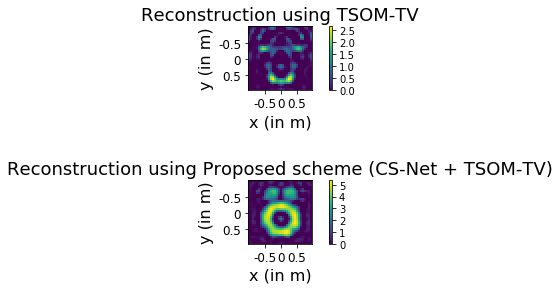

In [18]:
# Display Reconstruction of Austria Profile
plt.subplot(3,1,1)
plt.imshow(np.real(np.reshape(x_L2,[L,L])))
plt.xticks([L*0.25, L*0.5, L*0.75], [-0.5, 0, 0.5],fontsize = '12')
plt.yticks([L*0.25, L*0.5, L*0.75], [-0.5, 0, 0.5],fontsize = '12')
plt.xlabel('x (in m)', fontsize='16')
plt.ylabel('y (in m)', fontsize='16')
plt.title('Reconstruction using TSOM-TV', fontsize='18')
plt.colorbar()


plt.subplot(3,1,3)
plt.imshow(np.real(np.reshape(x_L,[L,L])))
plt.xticks([L*0.25, L*0.5, L*0.75], [-0.5, 0, 0.5],fontsize = '12')
plt.yticks([L*0.25, L*0.5, L*0.75], [-0.5, 0, 0.5],fontsize = '12')
plt.xlabel('x (in m)', fontsize='12')
plt.ylabel('y (in m)', fontsize='12')
plt.title('Reconstruction using Proposed scheme (CS-Net + TSOM-TV)', fontsize='18')
plt.colorbar()